# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing forest data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging and log transform the forest area variable 
- Adding the size rank variable 

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Linear regression base line models per country
    - Fitting baseline model (mean model)
    - Fitting simple model (time, population)
    
- Linear regression theory driven models per country (social)
    - Social theory driven model 
    - Full social model 

- Linear regression theory driven models per country (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model

Model comparison: 
- Compare model predictions 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import os
import pickle as pkl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

# Cleaning and combining data 

In [2]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

df.info

df.describe

<bound method NDFrame.describe of              iso                                     Country/Region    unit  \
0            CHN                                              China  MtCO2e   
1            USA                                      United States  MtCO2e   
2            IND                                              India  MtCO2e   
3            RUS                                             Russia  MtCO2e   
4            IDN                                          Indonesia  MtCO2e   
..           ...                                                ...     ...   
190          TUV                                             Tuvalu  MtCO2e   
191          NIU                                               Niue  MtCO2e   
192          FJI                                               Fiji  MtCO2e   
193  Data source                                      Climate Watch     NaN   
194     Data for  Location: World. Sectors/Subsectors: Total inc...     NaN   

        1990     

Only countains iso countries

Melting the wide df into a long df instead.

In [3]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='ghg')

#print(melted_df)

In [64]:
melted_df.describe()
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   iso             5983 non-null   object
 1   Country/Region  5983 non-null   object
 2   unit            5983 non-null   object
 3   Year            5983 non-null   object
 4   ghg             5983 non-null   object
dtypes: object(5)
memory usage: 233.8+ KB


In [65]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['ghg'] = melted_df['ghg'].astype(float)

In [66]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year      ghg
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


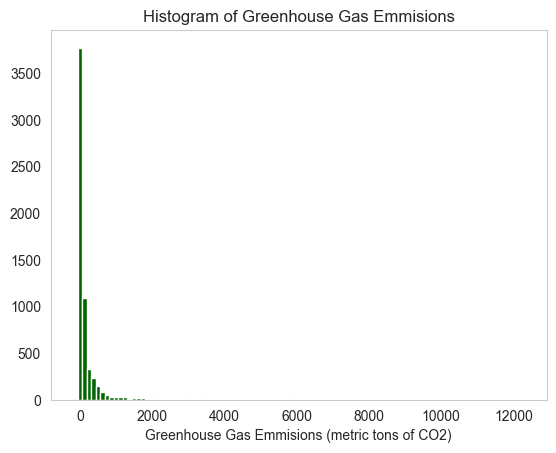

In [87]:
plt.hist(melted_df['ghg'], bins=100, color='darkgreen')
plt.title('Histogram of Greenhouse Gas Emmisions')
plt.xlabel('Greenhouse Gas Emmisions (metric tons of CO2)')
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. As it stands there are massive outliers.

A log transformation was done to greenhouse gas values in order to reduce the impact of outliers and attempt to normaloze the data.

In [71]:
# Adding a small value to each value in 'ghg' column to avoid logarithm of zero
melted_df['log_ghg'] = np.log(melted_df['ghg'] + 1e-20)

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year      ghg   log_ghg
0  CHN          China  MtCO2e  1990.0  2892.41  7.969845
1  USA  United States  MtCO2e  1990.0  5448.74  8.603140
2  IND          India  MtCO2e  1990.0  1020.11  6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520


C:\Users\marc1\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


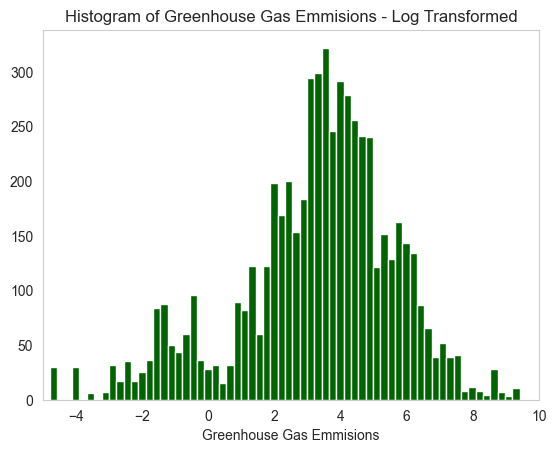

In [89]:
plt.hist(melted_df['log_ghg'], bins=250, color='darkgreen')
plt.title('Histogram of Greenhouse Gas Emmisions - Log Transformed')
plt.xlabel('Greenhouse Gas Emmisions')
# Setting x-axis limit
plt.xlim(left=-5)
plt.xlim(right=10)
plt.show()

It is still not perfect, but the greenhouse gasses are distributed far better and will be a more useful outcome to our models.

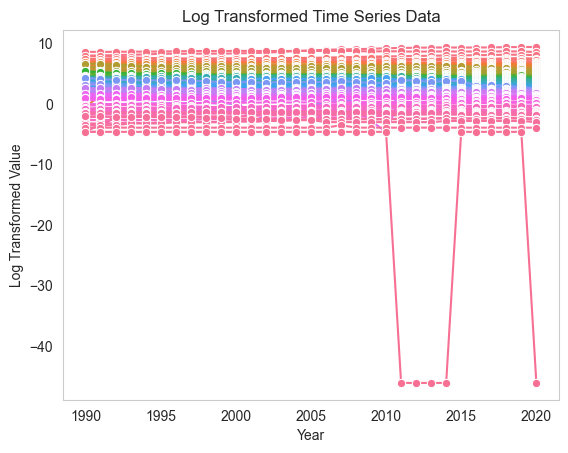

In [88]:
sns.lineplot(data=melted_df, x='Year', y='log_ghg', hue='iso', marker='o', legend=False)

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

### Add predictors to our GHG-dataset

In [90]:
#Read predictor file 

pred = pd.read_excel('git_data\predictor_data.xlsx')

display(pred)

,Country Name,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,Aruba,ABW,1960,54608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,130692579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1960,8622466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1960,97256290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,1960,5357195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17769,Swaziland,SWZ,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569174
17770,"Tanzania, United Republic of",TZA,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.751511
17771,Turkey,TUR,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352290
17772,"Venezuela, Bolivarian Republic o",VEN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.478761


In [94]:
melted_df = melted_df.rename(columns={'iso': 'Country Code'})

display(melted_df)

,Country Code,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023
5981,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702


In [93]:
ghg_full = pd.merge(melted_df, pred, on = ['Year', 'Country Code'], how = 'inner')
ghg_full = ghg_full.drop(columns=['Country Name'])

display(ghg_full)

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6746,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6747,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN,0.553662
6748,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN,0.605705
6749,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
ghg_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6751 entries, 0 to 6750
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6751 non-null   object 
 1   Country/Region      6751 non-null   object 
 2   unit                6751 non-null   object 
 3   Year                6751 non-null   float64
 4   ghg                 6750 non-null   float64
 5   log_ghg             6662 non-null   float64
 6   Population, total   5921 non-null   float64
 7   Land area (sq. km)  5797 non-null   float64
 8   WGI VA              4117 non-null   float64
 9   WGI PS              4073 non-null   float64
 10  WGI GE              4038 non-null   float64
 11  WGI RQ              4041 non-null   float64
 12  WGI RL              4114 non-null   float64
 13  WGI CC              4057 non-null   float64
 14  Education           3635 non-null   float64
 15  Innovation          2994 non-null   float64
 16  Social

Removing countries with all NaN in one column or half of the variables in the columns is NaN.

In [3]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
ghg_full_filtered = ghg_full[(ghg_full['Year'] >= 1996) & (ghg_full['Year'] <= 2020)]

# Identify countries with NaN in 'log_ghg' for years other than 1997 and 1999
countries_with_nan = ghg_full_filtered[
    (ghg_full_filtered['Year'] != 1997) & 
    (ghg_full_filtered['Year'] != 1999) & 
    (ghg_full_filtered['log_ghg'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
ghg_full_filtered = ghg_full_filtered[~ghg_full_filtered['Country Code'].isin(countries_with_nan)]

# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country/Region', 'unit', 'Year', 'ghg', 'log_ghg', 'Country Name', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = ghg_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
ghg_full_filtered = ghg_full_filtered[ghg_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

# Remove rows with 'Country Code' equal to 'NIU'
ghg_full_filtered = ghg_full_filtered[ghg_full_filtered['Country Code'] != 'NIU']

# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = ghg_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
ghg_full_filtered = ghg_full_filtered[~ghg_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

display(countries_with_nan)
# Display the filtered dataset
display(ghg_full_filtered)
print(len(forest_full_filtered['Country Code'].unique()))

Countries removed using country code: []


array([], dtype=object)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [4]:
print(len(ghg_full_filtered['Country Code'].unique()))
print(ghg_full_filtered.isna().sum())


152
Country Code          0
Country/Region        0
Year                  0
ghg                   0
log_ghg               0
Population, total     0
Land area (sq. km)    0
WGI VA                0
WGI PS                0
WGI GE                0
WGI RQ                0
WGI RL                0
WGI CC                0
ICT                   0
Health                0
dtype: int64


We end up with 152 countries, and the relevant predictors mostly have fewer than 60 NaN. Then we impute the data for each of the countries where at least half of the observations are not NaN.

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = ghg_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country/Region', 'unit', 'Year', 'ghg', 'log_ghg', 'Education', 'Innovation', 'Social Inequality']

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
ghg_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(ghg_full_imputed)

Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [7]:
# Verify the imputed data
print(ghg_full_imputed.isna().sum())

Country Code          0
Country/Region        0
Year                  0
ghg                   0
log_ghg               0
Population, total     0
Land area (sq. km)    0
WGI VA                0
WGI PS                0
WGI GE                0
WGI RQ                0
WGI RL                0
WGI CC                0
ICT                   0
Health                0
dtype: int64


In [9]:
ghg = ghg_full_imputed.drop(columns=['unit', 'Education', 'Innovation', 'Social Inequality'])
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


Delaying the ghg variable.

In [12]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
ghg['lagged_ghg'] = pd.NA

#Iterating over each row
for i in range(len(ghg)):
    country = ghg.loc[i, 'Country Code']
    year = ghg.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = ghg[(ghg['Country Code'] == country) & (ghg['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        ghg.loc[i, 'lagged_ghg'] = lagged_row['log_ghg'].values[0]

#Display the new dataframe 
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,4.729156
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [13]:
#Checking if the lagged is correct 
print(ghg[(ghg['Country Code'] == 'ZWE') & (ghg['Year'] == 2000.0)]['log_ghg'])

print(ghg[(ghg['Country Code'] == 'ZWE') & (ghg['Year'] == 1996.0)]['lagged_ghg'])


3324    3.724729
Name: log_ghg, dtype: float64
3322    3.724729
Name: lagged_ghg, dtype: object


In [14]:
ghg['lagged_ghg'] = pd.to_numeric(ghg['lagged_ghg'])
ghg = ghg.rename(columns={'Land area (sq. km)':'land_area'})
ghg = ghg.rename(columns={'Population, total':'population'})
ghg = ghg.dropna()

display(ghg)
ghg.info()

,Country Code,Country/Region,Year,ghg,log_ghg,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,42.23,3.743131,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711
3336,ZWE,Zimbabwe,2013.0,42.19,3.742183,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932
3337,ZWE,Zimbabwe,2014.0,40.34,3.697344,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121
3338,ZWE,Zimbabwe,2015.0,41.86,3.734331,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849


<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3339
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    2736 non-null   object 
 1   Country/Region  2736 non-null   object 
 2   Year            2736 non-null   float64
 3   ghg             2736 non-null   float64
 4   log_ghg         2736 non-null   float64
 5   population      2736 non-null   float64
 6   land_area       2736 non-null   float64
 7   WGI VA          2736 non-null   float64
 8   WGI PS          2736 non-null   float64
 9   WGI GE          2736 non-null   float64
 10  WGI RQ          2736 non-null   float64
 11  WGI RL          2736 non-null   float64
 12  WGI CC          2736 non-null   float64
 13  ICT             2736 non-null   float64
 14  Health          2736 non-null   float64
 15  lagged_ghg      2736 non-null   float64
dtypes: float64(14), object(2)
memory usage: 363.4+ KB


In [15]:
ghg.isna().sum()

Country Code      0
Country/Region    0
Year              0
ghg               0
log_ghg           0
population        0
land_area         0
WGI VA            0
WGI PS            0
WGI GE            0
WGI RQ            0
WGI RL            0
WGI CC            0
ICT               0
Health            0
lagged_ghg        0
dtype: int64

In [18]:
len(ghg['Country Code'].unique())

152

In [96]:
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,Zimbabwe,2012.0,42.23,3.743131,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711
2732,ZWE,Zimbabwe,2013.0,42.19,3.742183,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932
2733,ZWE,Zimbabwe,2014.0,40.34,3.697344,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121
2734,ZWE,Zimbabwe,2015.0,41.86,3.734331,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849


In [97]:
ghg_size = ghg[['Country Code', 'land_area', 'Year']]

ghg_group = ghg_size.groupby('Country Code')['land_area'].mean()


ghg_size_mean = ghg_group.reset_index(name='mean_land_area')
display(ghg_size_mean)

#Sort forest by population in ascending order
ghg_size_mean = ghg_size_mean.sort_values(by='mean_land_area', ascending=True).reset_index(drop=True)

ghg_size_mean['Size_rank'] = ghg_size_mean.index + 1

display(ghg_size_mean)

,Country Code,mean_land_area
0,AFG,652230.0
1,AGO,1246700.0
2,ALB,27400.0
3,ARE,71020.0
4,ARG,2736690.0
...,...,...
147,VUT,12190.0
148,WSM,2830.0
149,ZAF,1213090.0
150,ZMB,743390.0


,Country Code,mean_land_area,Size_rank
0,NRU,2.000000e+01,1
1,TUV,3.000000e+01,2
2,MHL,1.800000e+02,3
3,MDV,3.000000e+02,4
4,MLT,3.200000e+02,5
...,...,...,...
147,BRA,8.358140e+06,148
148,CAN,8.965590e+06,149
149,USA,9.154341e+06,150
150,CHN,9.388214e+06,151


In [98]:
#Merging the size rank into ghg again
ghg = ghg.merge(ghg_size_mean[['Country Code', 'Size_rank']], on='Country Code')
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg,Size_rank
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793,121
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068,121
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024,121
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895,121
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,Zimbabwe,2012.0,42.23,3.743131,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711,103
2732,ZWE,Zimbabwe,2013.0,42.19,3.742183,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932,103
2733,ZWE,Zimbabwe,2014.0,40.34,3.697344,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121,103
2734,ZWE,Zimbabwe,2015.0,41.86,3.734331,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849,103


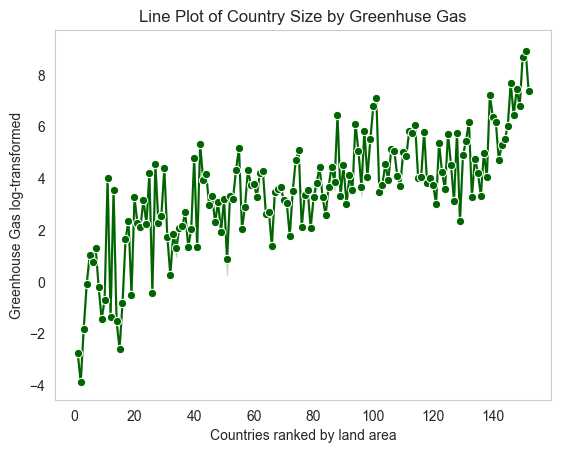

In [100]:
sns.lineplot(x='Size_rank', y='log_ghg', data = ghg,marker='o', color='darkgreen')
plt.title('Line Plot of Country Size by Greenhuse Gas')
plt.xlabel('Countries ranked by land area')
plt.ylabel('Greenhouse Gas log-transformed')
plt.show()

Ploted to explore if there, in reality, is a relationship. In this case, it seems that there is.

In [101]:
ghg.to_csv('git_data\GHG-modelling.csv', index=False)

# Data Exploration

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Load in cleaned data 
ghg = pd.read_csv('git_data/ghg-modelling.csv')
ghg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    2736 non-null   object 
 1   Country/Region  2736 non-null   object 
 2   Year            2736 non-null   float64
 3   ghg             2736 non-null   float64
 4   log_ghg         2736 non-null   float64
 5   population      2736 non-null   float64
 6   land_area       2736 non-null   float64
 7   WGI VA          2736 non-null   float64
 8   WGI PS          2736 non-null   float64
 9   WGI GE          2736 non-null   float64
 10  WGI RQ          2736 non-null   float64
 11  WGI RL          2736 non-null   float64
 12  WGI CC          2736 non-null   float64
 13  ICT             2736 non-null   float64
 14  Health          2736 non-null   float64
 15  lagged_ghg      2736 non-null   float64
 16  Size_rank       2736 non-null   int64  
dtypes: float64(14), int64(1), object(

### Plotting and data exploration

Forest area per country over years.

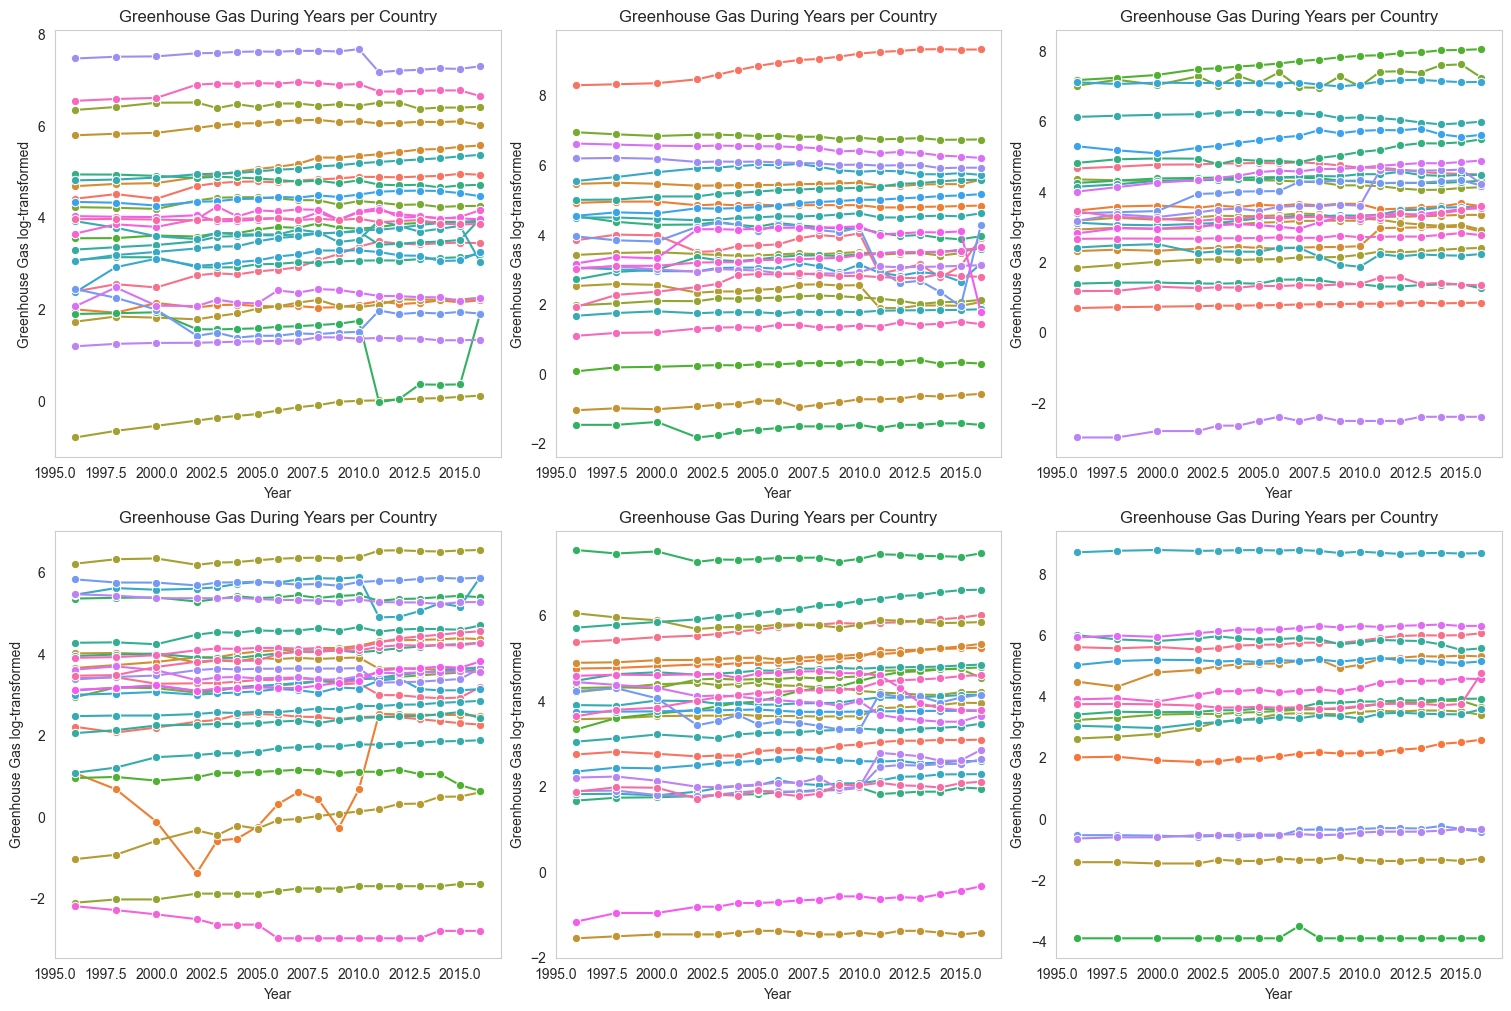

In [103]:
#Dividing by contries
countries = ghg['Country Code'].unique()
countries_per_fig = 27
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = ghg[ghg['Country Code'].isin(group)]
    sns.lineplot(x='Year', y='log_ghg', data= data, hue = 'Country Code', marker='o', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    ax.set_title('Greenhouse Gas During Years per Country')
    #ax.set_xlabel('Country Code')
    ax.set_ylabel('Greenhouse Gas log-transformed')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.show()

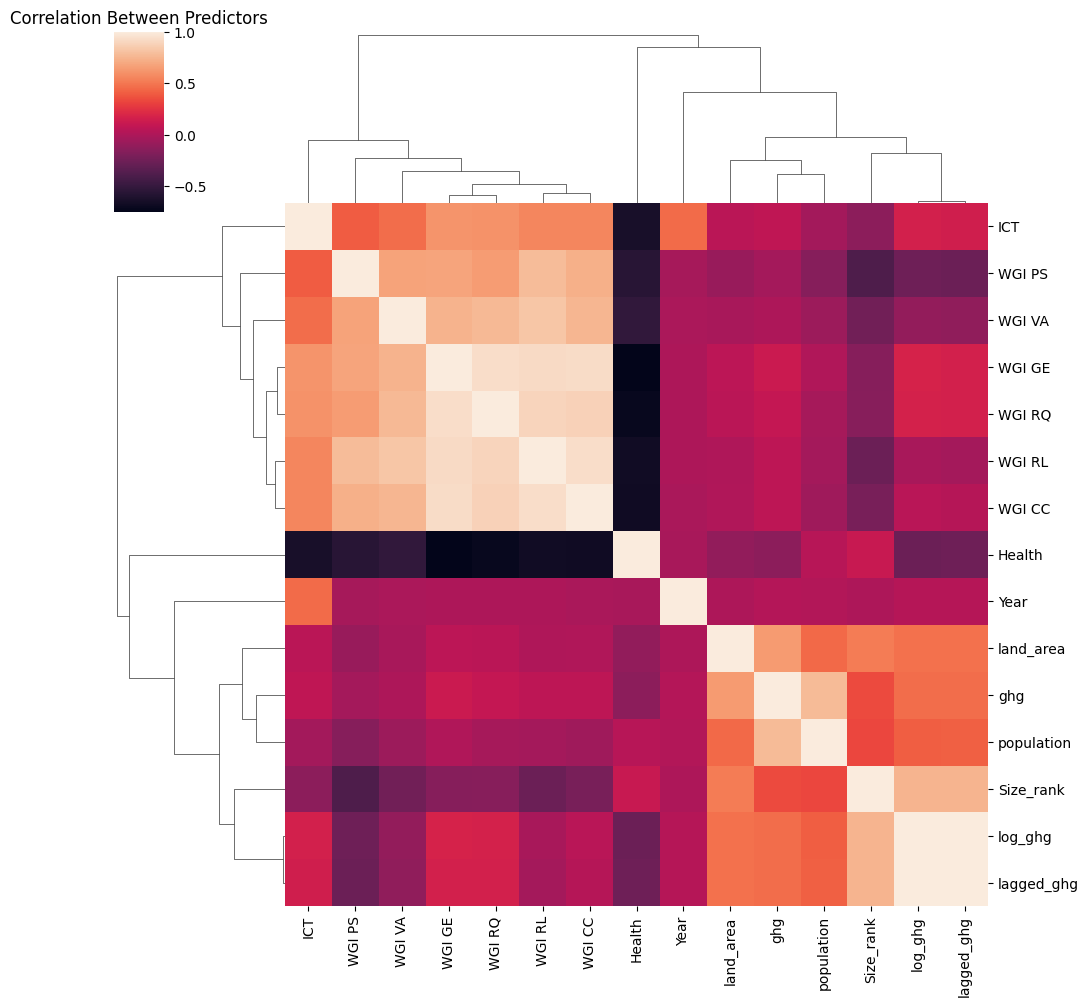

In [5]:
ghg_num = ghg[ghg.select_dtypes(exclude=['object']).columns]

sns.clustermap(ghg_num.corr())
plt.title('Correlation Between Predictors')
plt.show()

### Checking for outliers 

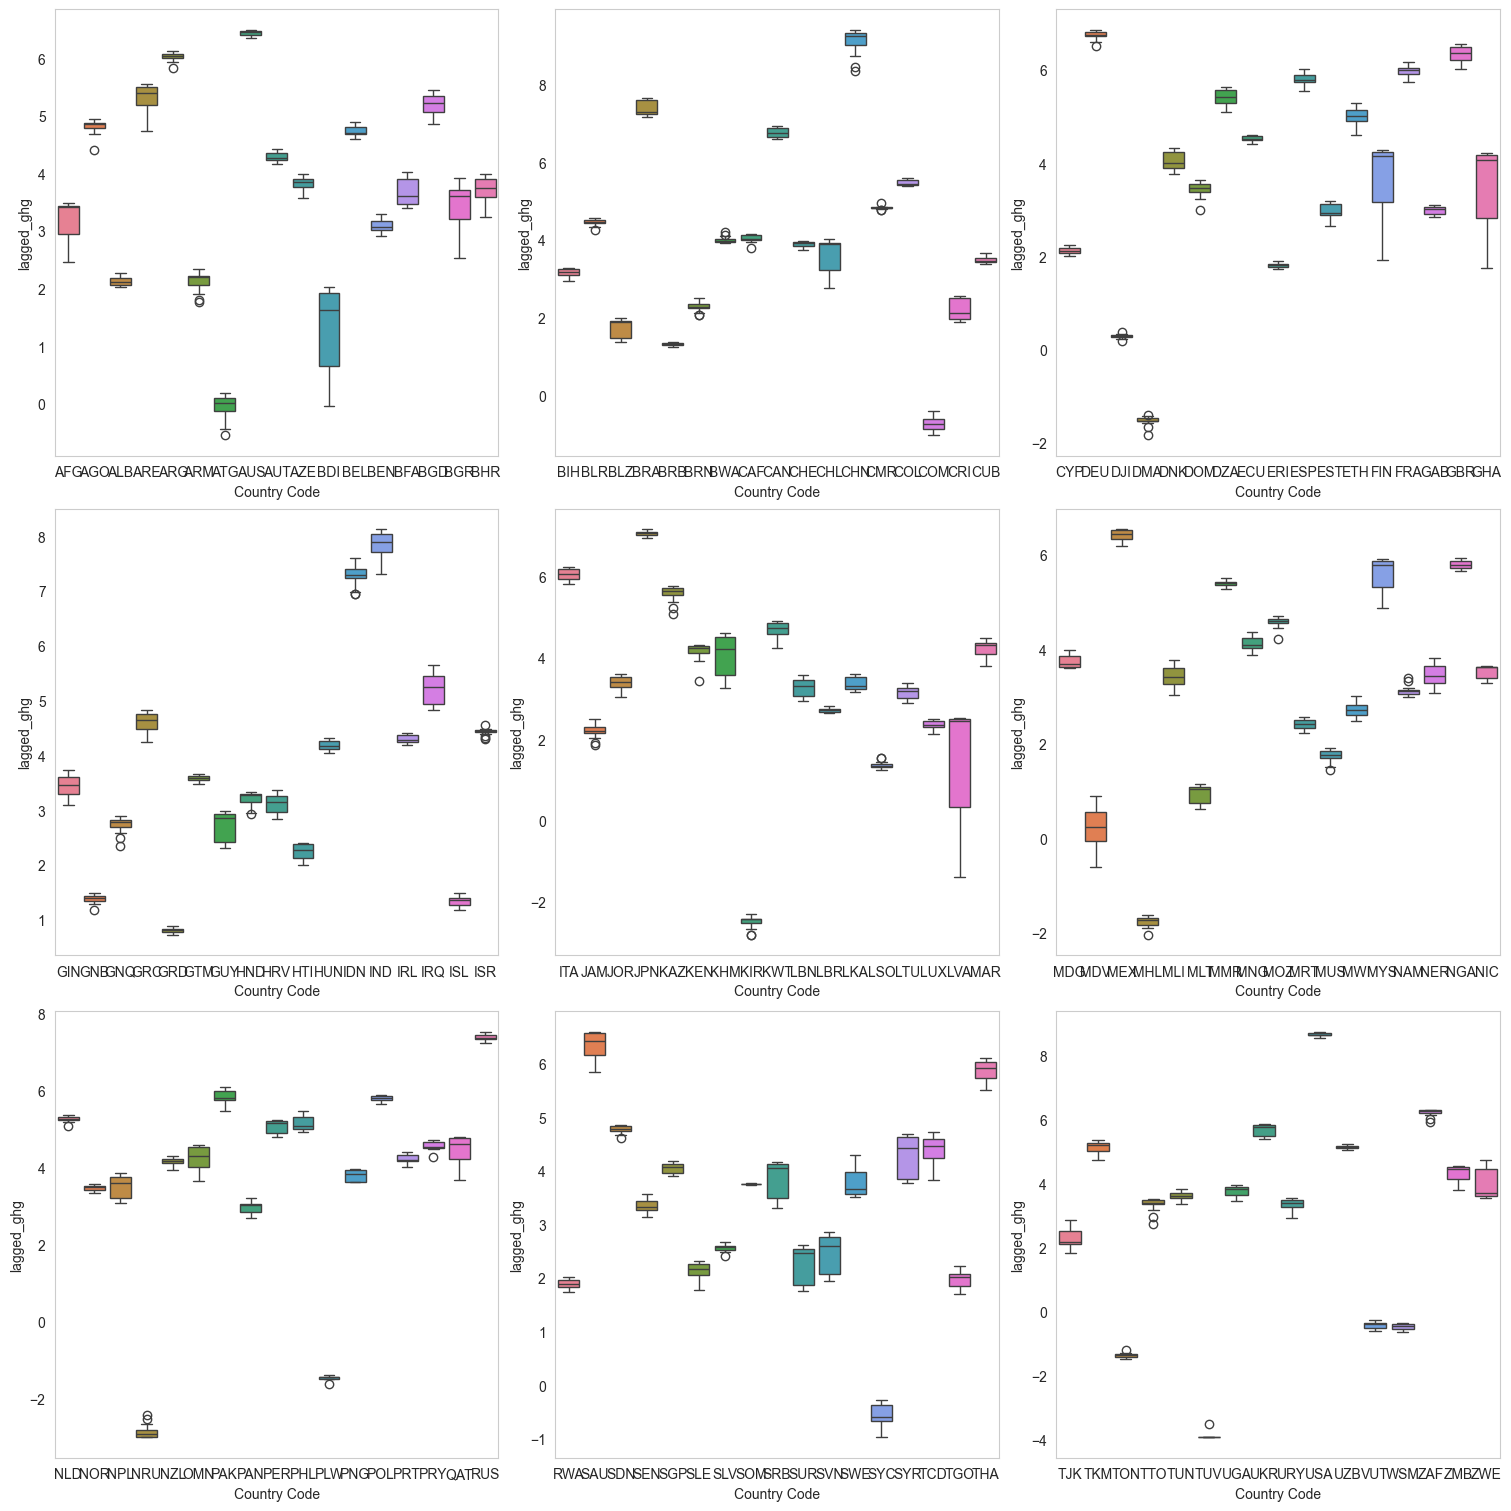

In [105]:
#Dividing by contries
countries = ghg['Country Code'].unique()
countries_per_fig = 17
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = ghg[ghg['Country Code'].isin(group)]
    sns.boxplot(x='Country Code', y='lagged_ghg', data= data, hue = 'Country Code', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [6]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_ghg'].quantile(0.25)
    Q3 = group['lagged_ghg'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_ghg'] < lower_bound) | (group['lagged_ghg'] > upper_bound)]

# Group by 'Country Code' and apply the outlier detection function
outliers = ghg.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Total number of outliers
total_outliers = outliers.shape[0]
print("\nTotal number of outliers:", total_outliers)

# Number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()
print("\nNumber of outliers per 'Country Code':")
print(outliers_per_country)
print(f'Number of countries with outliers: {len(outliers_per_country)}')
print(f'Number of countries with 2 or more outliers: {(outliers_per_country > 2).sum()}')
print(f'Max number of outliers per country: {max(outliers_per_country)}')


Total number of outliers: 60

Number of outliers per 'Country Code':
Country Code
AGO    1
ARG    1
ARM    2
ATG    1
BLR    1
BRN    2
BWA    2
CAF    1
CHN    2
CMR    3
DEU    1
DJI    2
DMA    3
DOM    1
GNB    1
GNQ    2
HND    1
IDN    2
ISR    4
JAM    2
KAZ    2
KEN    1
KIR    2
LSO    2
MHL    1
MOZ    1
MUS    1
NAM    2
NLD    1
NRU    2
PLW    1
PRY    1
SDN    1
SLV    1
TON    1
TTO    2
TUV    1
ZAF    2
dtype: int64
Number of countries with outliers: 38
Number of countries with 2 or more outliers: 3
Max number of outliers per country: 4


C:\Users\mlj\AppData\Local\Temp\ipykernel_5844\1200963551.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = ghg.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)


Maybe consider removing at least DJI as it is constant and MLT is almost constant except for year 2016, and OMN is the same as they proved to be problimatic in the forest dataset.

In [7]:
big_outliers = outliers_per_country[(outliers_per_country > 1)]

print(big_outliers)

Country Code
ARM    2
BRN    2
BWA    2
CHN    2
CMR    3
DJI    2
DMA    3
GNQ    2
IDN    2
ISR    4
JAM    2
KAZ    2
KIR    2
LSO    2
NAM    2
NRU    2
TTO    2
ZAF    2
dtype: int64


<Axes: xlabel='Country Code', ylabel='log_ghg'>

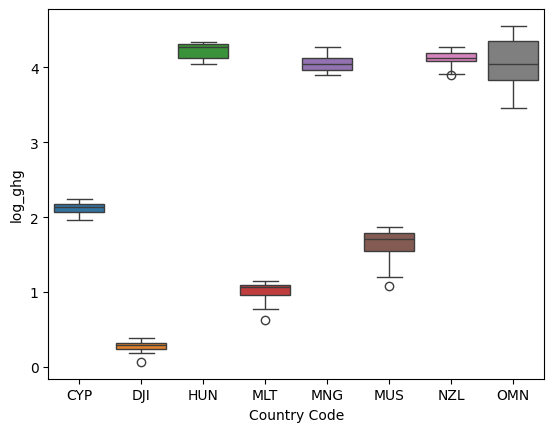

In [8]:
big_outliers = ['CYP', 'DJI','HUN', 'MLT', 'MNG', 'MUS', 'NZL', 'OMN' ]
data = ghg[ghg['Country Code'].isin(big_outliers)]
sns.boxplot(x='Country Code', y='log_ghg', data= data, hue = 'Country Code', legend=False)


<Axes: xlabel='Year', ylabel='log_ghg'>

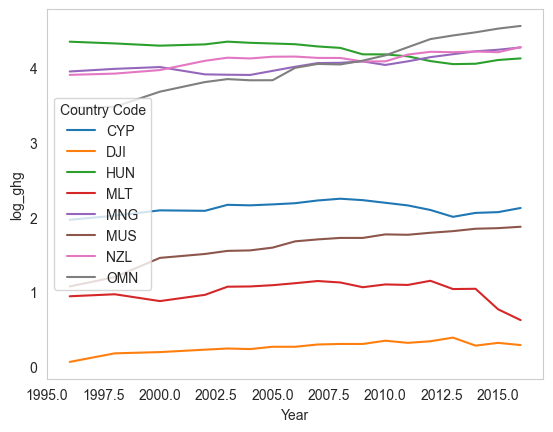

In [111]:
sns.lineplot(x='Year', y='log_ghg', data= data, hue = 'Country Code')

They proved to be okay so they remained in the model.

# Data splitting

In [41]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Data splitting in training, validation and test sets. 

In [42]:
colors=sns.color_palette('Paired'); my_palette={'train': colors[1], 'test': colors[0], 'val':colors[2]}

In [43]:
#Defining the features (X) and the target variable (y)
X = ghg.drop(columns=['log_ghg', 'Country/Region', 'ghg']) 
y = ghg['lagged_ghg'] 

#Defining the group variable (Country)
groups = ghg['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [44]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 14) (1908,)
Validation set shape: (414, 14) (414,)
Test set shape: (414, 14) (414,)


Checking training data for representative sample. 

In [45]:
#Plotting the size rank for each split 

val = X_val['Size_rank']
test = X_test['Size_rank']
train = X_train['Size_rank']

size_df = pd.DataFrame({
    'val': val,
    'test': test,
    'train': train
})


size_df = pd.melt(size_df)
display(size_df)


,variable,value
0,val,NaN
1,val,NaN
2,val,NaN
3,val,NaN
4,val,NaN
...,...,...
8203,train,103.0
8204,train,103.0
8205,train,103.0
8206,train,103.0


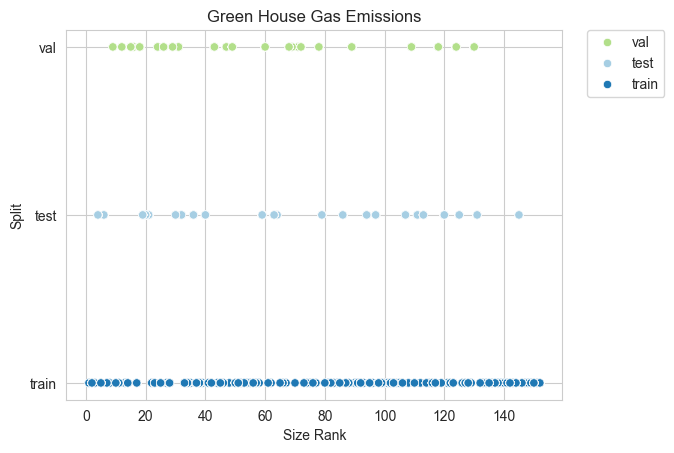

In [46]:
sns.scatterplot(data=size_df, 
                y='variable', 
                x='value', 
                marker='o', 
                hue='variable', palette=my_palette)

plt.title('Green House Gas Emissions')
plt.ylabel('Split')
plt.xlabel('Size Rank')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Data Modelling

In [69]:
performances = []

In [48]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import pickle as pkl
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Baseline Median Dummy Model 

This portion calculates the mean log-transformed greenhouse gas score from X_train to be fit on the other splits.

In [70]:
# Calculate median lagged_agro for X_train
median_lagged_agro_train = X_train['lagged_ghg'].median()

# Function to add median values to a dataset
def add_median_values(df, median_value):
    df['median_prediction'] = median_value
    return df

# List of datasets to process
datasets = [(X_train, 'X_train'), (X_val, 'X_val'), (X_test, 'X_test')]

# Iterate over the datasets and add the median values
for x, name in datasets:
    x = add_median_values(x, median_lagged_agro_train)


C:\Users\mlj\AppData\Local\Temp\ipykernel_5844\3186784761.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_prediction'] = median_value


In [71]:
sorted_X_val = X_val.sort_values(by='Country Code')
display(sorted_X_val)


,Country Code,Year,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg,Size_rank,median_prediction
216,BEN,1996.0,6203860.0,112760.0,0.259205,1.050372,-0.380564,-0.176318,0.052316,-0.548115,-3.407600,0.642331,3.126761,71,3.950377
233,BEN,2016.0,11260085.0,112760.0,0.408386,-0.008784,-0.624919,-0.583056,-0.625831,-0.529120,26.760221,0.690871,3.294354,71,3.950377
232,BEN,2015.0,10932783.0,112760.0,0.294566,-0.020496,-0.681488,-0.621767,-0.554906,-0.563475,29.226725,0.717781,3.274878,71,3.950377
231,BEN,2014.0,10614844.0,112760.0,0.264593,0.027140,-0.484983,-0.620842,-0.485179,-0.669144,27.953034,0.718178,3.258865,71,3.950377
230,BEN,2013.0,10308730.0,112760.0,0.155496,0.301189,-0.508523,-0.415550,-0.567833,-0.745443,31.783311,0.700578,3.208017,71,3.950377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,VUT,1998.0,183088.0,12190.0,0.639759,1.113963,-0.116156,-0.231645,0.333780,0.238910,-3.948645,0.552318,-0.597837,26,3.950377
2646,VUT,1996.0,174714.0,12190.0,0.628802,1.035551,-0.080948,-0.213357,0.323561,0.216309,-6.332881,0.552318,-0.562119,26,3.950377
2662,VUT,2015.0,276438.0,12190.0,0.592993,0.458487,-0.819739,-0.332274,0.124422,-0.122393,22.176401,0.673688,-0.446287,26,3.950377
2653,VUT,2006.0,222923.0,12190.0,0.454070,1.349654,-0.412535,0.001730,0.567534,0.192251,3.378596,0.629607,-0.342490,26,3.950377


Fitting the model

In [72]:
model = 'Baseline Median Model'

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    
    
    # Calculate performance metrics for the baseline model on the current data split
    mae = mean_absolute_error(y, x['median_prediction'])
    mse = mean_squared_error(y, x['median_prediction'])  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE
    mape = mean_absolute_percentage_error(y, x['median_prediction'])
    r2 = r2_score(y, x['median_prediction'])

    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
    })


## Simple Linear Model with Demographic Predictors

In [73]:

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Simple Demographic'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })


## Linear Models with Social and Governance Predictors

**Social Predictors (Voice & Accountability, Health):**
- Adds `WGI VA` and `Health` to demographic predictors.
- Fits and evaluates the linear model, stores, and visualizes performance metrics.

**Full Social Model (Including ICT):**
- Adds `ICT` to the social predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

**Governance Predictors (Regulatory Quality, Government Effectiveness, Rule of Law):**
- Adds `WGI RQ`, `WGI GE`, and `WGI RL` to demographic predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

**Full Governance Model (Including Political Stability, Control of Corruption):**
- Adds `WGI PS` and `WGI CC` to the governance predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

## Linear models with social predictors 

### Theory driven, voice and accountability and health

In [74]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Social Theory'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Full social model including ICT 

In [75]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]

soc_full = LinearRegression().fit(X_train_selected, y_train)

model = 'Social Full'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]
    preds = soc_full.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

## Linear models with governance predictors 

### Theory driven: regulatory quality, government effectiveness, and rule of law

In [76]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Theory'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Full model including political stability and control of corruption 

In [77]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]

gov_full = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]
    preds = gov_full.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

## Comparison of linear models

In [78]:
perf_df = pd.DataFrame(performances)

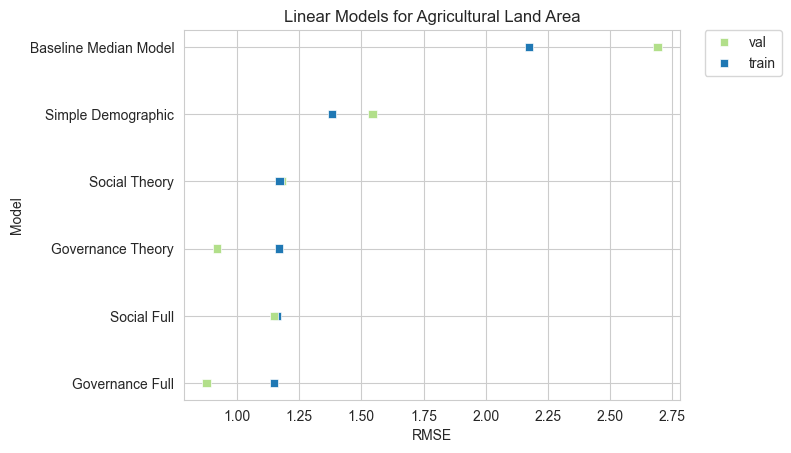

In [79]:
val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Linear Models for Agricultural Land Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()

In [80]:
display(val_df)

,model,split,rmse
0,Baseline Median Model,train,2.1737
1,Baseline Median Model,val,2.6913
2,Simple Demographic,train,1.3818
3,Simple Demographic,val,1.5445
4,Social Theory,train,1.1698
5,Social Theory,val,1.1779
6,Social Full,train,1.1597
7,Social Full,val,1.1490
8,Governance Theory,train,1.1684
9,Governance Theory,val,0.9191


Here we see that the social full and the governance full are the best in respective categories.

## Assessing our linear regressions

Here we check that there are not obvious trends of the validation predictions in our social full model and our governance full model. 

#### Social full model 

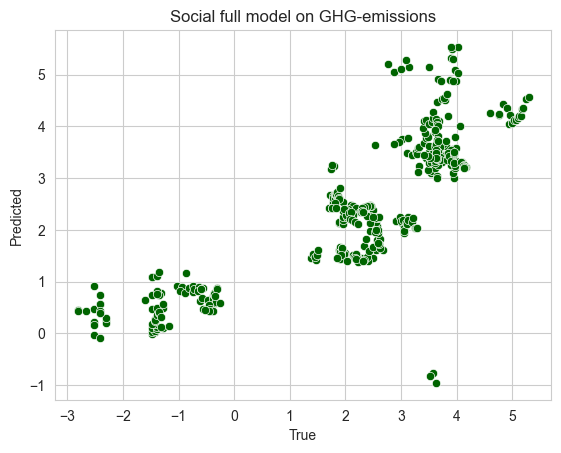

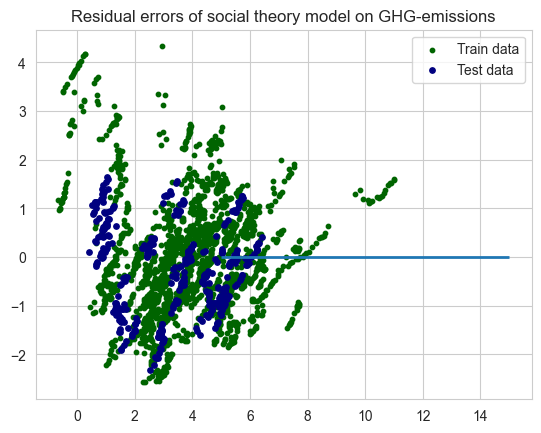

In [39]:

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]
X_test_selected =X_test[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]
soc_val = LinearRegression().fit(X_train_selected, y_train)

X_val_selected = X_val[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]
soc_preds = soc_val.predict(X_val_selected)
absolute_error = np.abs(soc_preds - y_val)

sns.scatterplot(x=y_val, y=soc_preds, color = 'Darkgreen')
plt.title('Social full model on GHG-emissions')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

# plotting residual errors in training data 
plt.scatter(soc_val.predict(X_train_selected), 
            soc_val.predict(X_train_selected) - y_train, 
            color="darkgreen", s=10, 
            label='Train data') 
  
# plotting residual errors in test data 
plt.scatter(soc_val.predict(X_test_selected), 
            soc_val.predict(X_test_selected) - y_test, 
            color="navy", s=15, 
            label='Test data') 

plt.hlines(y=0, xmin=5, xmax=15, linewidth=2) 
plt.legend(loc='upper right') 
plt.title("Residual errors of social theory model on GHG-emissions") 
plt.show() 

#### Governance full model

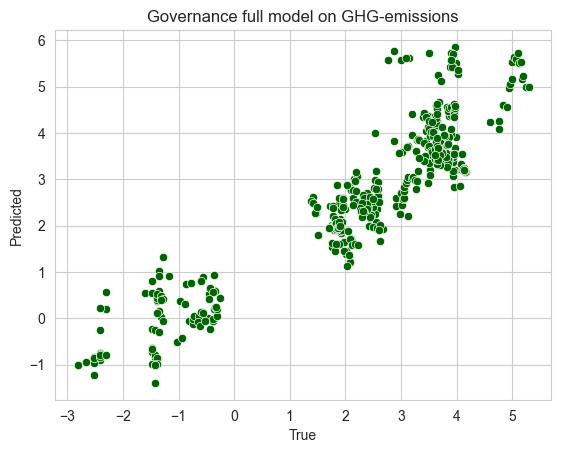

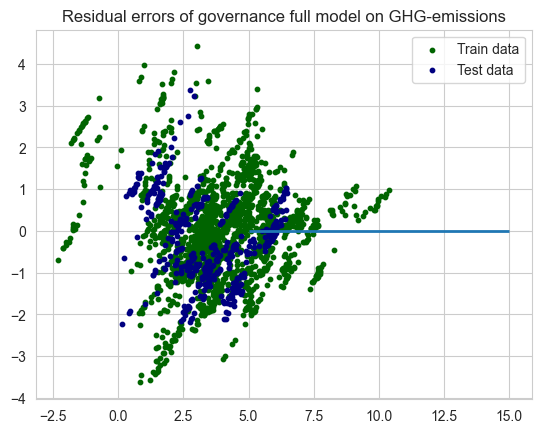

In [40]:

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI CC', 'WGI PS']]
X_test_selected =X_test[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI CC', 'WGI PS']]
gov_val = LinearRegression().fit(X_train_selected, y_train)

X_val_selected = X_val[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI CC', 'WGI PS']]
gov_preds = gov_val.predict(X_val_selected)
absolute_error = np.abs(gov_preds - y_val)

sns.scatterplot(x=y_val, y=gov_preds, color = 'Darkgreen')
plt.title('Governance full model on GHG-emissions')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

# plotting residual errors in training data 
plt.scatter(gov_val.predict(X_train_selected), 
            gov_val.predict(X_train_selected) - y_train, 
            color="darkgreen", s=10, 
            label='Train data') 
  
# plotting residual errors in test data 
plt.scatter(gov_val.predict(X_test_selected), 
            gov_val.predict(X_test_selected) - y_test, 
            color="navy", s=10, 
            label='Test data') 

plt.hlines(y=0, xmin=5, xmax=15, linewidth=2) 
plt.legend(loc='upper right') 
plt.title("Residual errors of governance full model on GHG-emissions") 
plt.show() 

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [30]:

from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

c:\Users\mlj\OneDrive - Aarhus Universitet\MA 2. Semester\Data Science\DataScienceExam\data_sci_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Combined MERF Model

In [81]:
model = 'MERF Full'

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'lagged_ghg', 'Size_rank', 'median_prediction'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'lagged_ghg', 'Size_rank', 'median_prediction'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4)
        })

INFO     [merf.py:307] Training GLL is -7163.167092961013 at iteration 1.
INFO     [merf.py:307] Training GLL is -10466.249338645506 at iteration 2.
INFO     [merf.py:307] Training GLL is -10745.00912162931 at iteration 3.
INFO     [merf.py:307] Training GLL is -10684.034957571583 at iteration 4.
INFO     [merf.py:307] Training GLL is -10703.90014229067 at iteration 5.
INFO     [merf.py:307] Training GLL is -10778.112292879125 at iteration 6.
INFO     [merf.py:307] Training GLL is -10712.193473731375 at iteration 7.
INFO     [merf.py:307] Training GLL is -10681.429150975464 at iteration 8.
INFO     [merf.py:307] Training GLL is -10583.06448477239 at iteration 9.
INFO     [merf.py:307] Training GLL is -10574.566635779433 at iteration 10.
INFO     [merf.py:307] Training GLL is -10581.129542921386 at iteration 11.
INFO     [merf.py:307] Training GLL is -10545.63783756516 at iteration 12.
INFO     [merf.py:307] Training GLL is -10520.430182358406 at iteration 13.
INFO     [merf.py:307] Tra

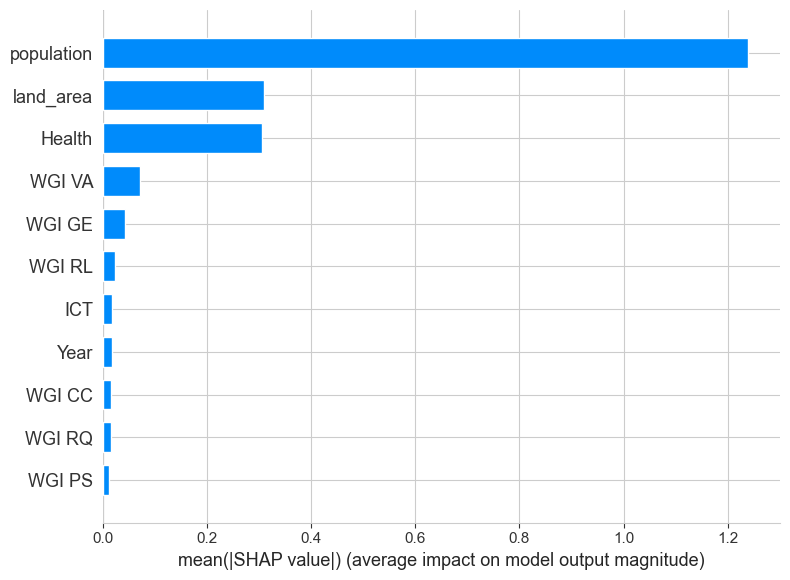

In [45]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [86]:
# Define the model name
model = "Government MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'lagged_ghg', 'Size_rank', 'median_prediction', 'WGI VA', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'lagged_ghg', 'Size_rank', 'median_prediction', 'WGI VA', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7106.412761801709 at iteration 1.
INFO     [merf.py:307] Training GLL is -10185.769272080253 at iteration 2.
INFO     [merf.py:307] Training GLL is -10284.41149951196 at iteration 3.
INFO     [merf.py:307] Training GLL is -10333.881342015278 at iteration 4.
INFO     [merf.py:307] Training GLL is -10316.688420944805 at iteration 5.
INFO     [merf.py:307] Training GLL is -10273.486166288802 at iteration 6.
INFO     [merf.py:307] Training GLL is -10375.101162457768 at iteration 7.
INFO     [merf.py:307] Training GLL is -10383.324540670745 at iteration 8.
INFO     [merf.py:307] Training GLL is -10325.389270082396 at iteration 9.
INFO     [merf.py:307] Training GLL is -10390.432086153949 at iteration 10.
INFO     [merf.py:307] Training GLL is -10357.709963807456 at iteration 11.
INFO     [merf.py:307] Training GLL is -10390.15170655134 at iteration 12.
INFO     [merf.py:307] Training GLL is -10364.769372749573 at iteration 13.
INFO     [merf.py:307] T

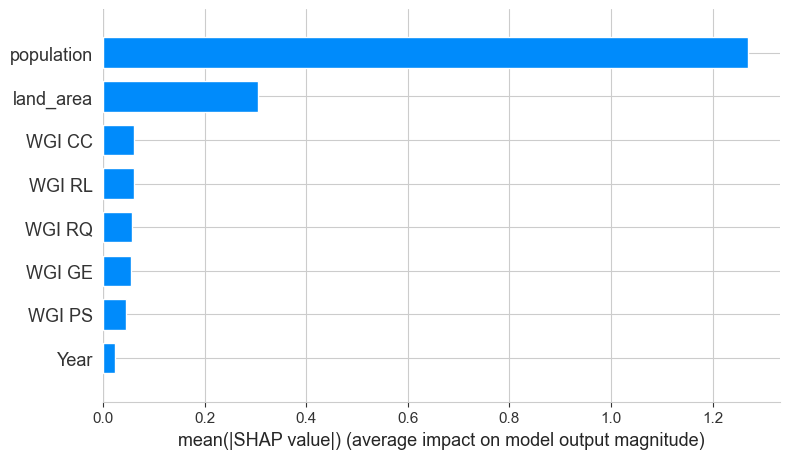

In [50]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [83]:
# Define the model name
model = "Social MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'lagged_ghg', 'Size_rank', 'median_prediction', 'WGI PS','WGI GE','WGI RQ','WGI RL','WGI CC'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'lagged_ghg', 'Size_rank', 'median_prediction', 'WGI PS','WGI GE','WGI RQ','WGI RL','WGI CC'])

    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7189.058644371026 at iteration 1.
INFO     [merf.py:307] Training GLL is -10619.456900145917 at iteration 2.
INFO     [merf.py:307] Training GLL is -10897.137281729247 at iteration 3.
INFO     [merf.py:307] Training GLL is -10829.34662485453 at iteration 4.
INFO     [merf.py:307] Training GLL is -10775.343540806378 at iteration 5.
INFO     [merf.py:307] Training GLL is -10839.501680340562 at iteration 6.
INFO     [merf.py:307] Training GLL is -10791.686339396203 at iteration 7.
INFO     [merf.py:307] Training GLL is -10843.277735440912 at iteration 8.
INFO     [merf.py:307] Training GLL is -10786.959040709735 at iteration 9.
INFO     [merf.py:307] Training GLL is -10843.863226764246 at iteration 10.
INFO     [merf.py:307] Training GLL is -10882.180953404159 at iteration 11.
INFO     [merf.py:307] Training GLL is -10897.298750035801 at iteration 12.
INFO     [merf.py:307] Training GLL is -10962.77320021085 at iteration 13.
INFO     [merf.py:307] T

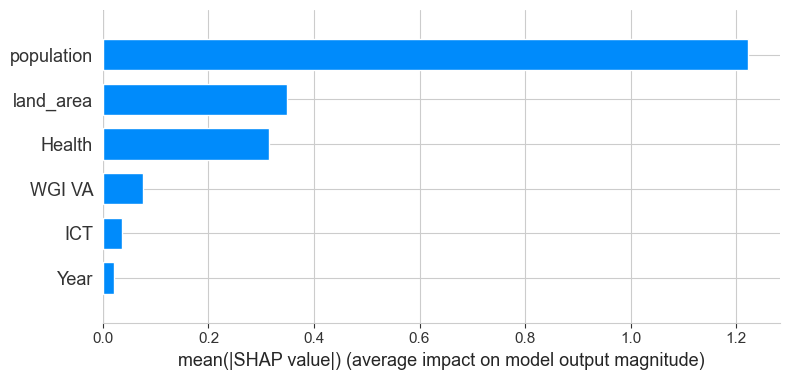

In [54]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

## Comparison of linear and MERF models 

In [87]:
## Comparison of linear and MERF models 
perf_df = pd.DataFrame(performances)


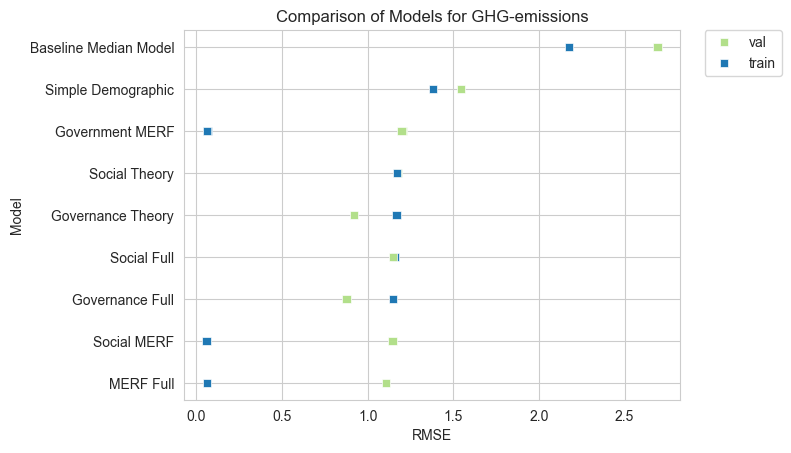

,model,split,rmse,mae,mape,r2
0,Baseline Median Model,train,2.1737,NaN,NaN,NaN
1,Baseline Median Model,val,2.6913,NaN,NaN,NaN
2,Simple Demographic,train,1.3818,NaN,NaN,NaN
3,Simple Demographic,val,1.5445,NaN,NaN,NaN
4,Social Theory,train,1.1698,NaN,NaN,NaN
5,Social Theory,val,1.1779,NaN,NaN,NaN
6,Social Full,train,1.1597,NaN,NaN,NaN
7,Social Full,val,1.1490,NaN,NaN,NaN
8,Governance Theory,train,1.1684,NaN,NaN,NaN
9,Governance Theory,val,0.9191,NaN,NaN,NaN


In [88]:

val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for GHG-emissions')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()

display(val_df)

# Ridge and Lasso CV

We can try to reguralize our best linear models in the social and governmental categories, which are the social full and the governance full. 

In [89]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

In [90]:
X_train = X_train.drop(columns=['Country Code'])
X_val = X_val.drop(columns=['Country Code'])
X_test = X_test.drop(columns=['Country Code'])

Our WGI indicators are all standardized, but we standardize population, land_area, and ICT. We want to keep the rest as is, because they are modelling fixed effects such as year and size rank.   

In [91]:
scaler = StandardScaler()
X_train[['population','land_area','ICT']] = scaler.fit_transform(X_train[['population','land_area','ICT']])
X_val[['population','land_area','ICT']] = scaler.transform(X_val[['population','land_area','ICT']])
X_test[['population','land_area','ICT']] = scaler.transform(X_test[['population','land_area','ICT']])

## Social theory model regularization



### Ridge regularization CV on full social model 


In [102]:

#Setting alphas to cover a large space
alphas = 10**np.linspace(10,-2,100)*0.5

#Choosing the simple and social predictors 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

ridgecv.fit(X_train_selected, y_train)

ridgecv.alpha_

#Fitting the ridge model with the estimated best alpha on our full social linear model
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]

ridge_high = Ridge(ridgecv.alpha_)
ridge_reg = ridge_high.fit(X_train_selected, y_train)

model = 'Social Full Ridge CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]
    preds = ridge_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })




### Lasso regularization on full social model


In [103]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]

lassocv = LassoCV(alphas = alphas)

lassocv.fit(X_train_selected, y_train)

lassocv.alpha_ 

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]

lasso = Lasso(lassocv.alpha_)
lasso_reg = lasso.fit(X_train_selected, y_train)


model = 'Social Full Lasso CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI VA', 'Health', 'ICT']]
    preds = lasso_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })



### Plotting and comparing


In [94]:
perf_df = pd.DataFrame(performances)


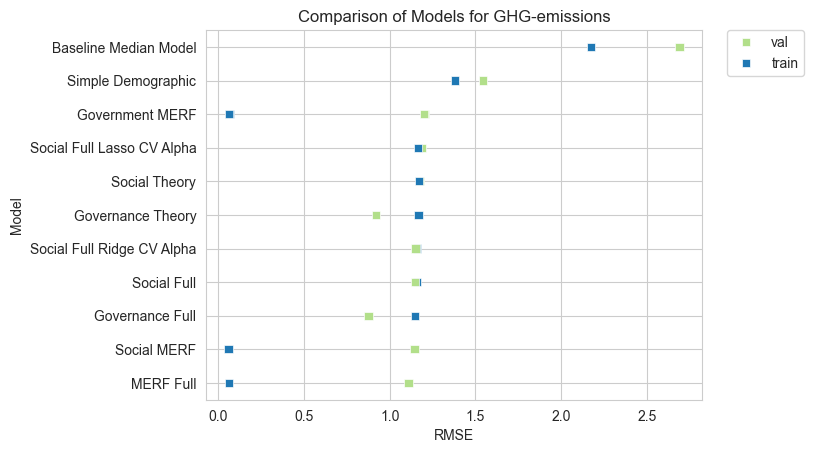

,model,split,rmse,mae,mape,r2
0,Baseline Median Model,train,2.1737,NaN,NaN,NaN
1,Baseline Median Model,val,2.6913,NaN,NaN,NaN
2,Simple Demographic,train,1.3818,NaN,NaN,NaN
3,Simple Demographic,val,1.5445,NaN,NaN,NaN
4,Social Theory,train,1.1698,NaN,NaN,NaN
5,Social Theory,val,1.1779,NaN,NaN,NaN
6,Social Full,train,1.1597,NaN,NaN,NaN
7,Social Full,val,1.1490,NaN,NaN,NaN
8,Governance Theory,train,1.1684,NaN,NaN,NaN
9,Governance Theory,val,0.9191,NaN,NaN,NaN


In [95]:

val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for GHG-emissions')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()
display(val_df)



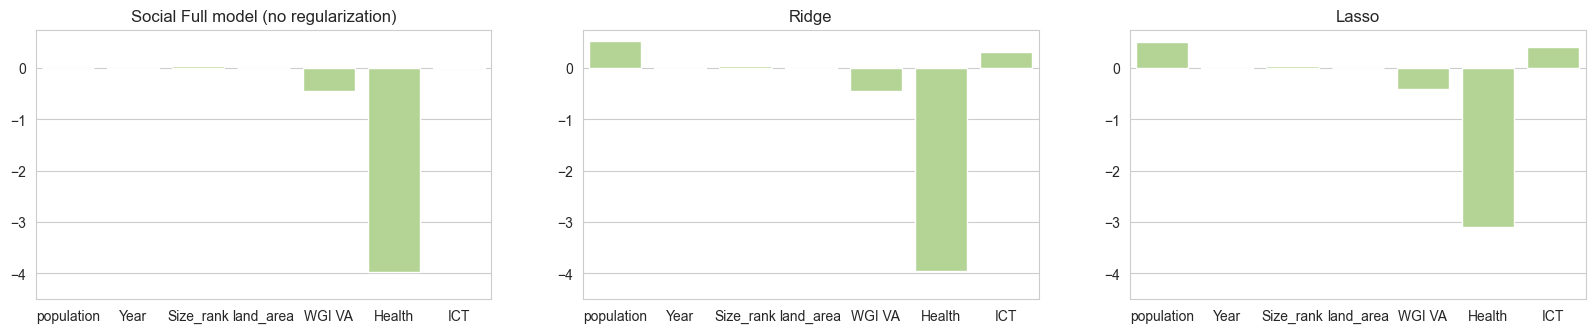

In [114]:

fig, ax = plt.subplots(ncols=3, figsize=(20,3.5))
sns.barplot(x=X_train_selected.columns, y=lasso_reg.coef_, ax=ax[2], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=ridge_reg.coef_, ax=ax[1], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=soc_full.coef_, ax=ax[0], color=sns.color_palette('Paired')[2])
for a in ax:
    a.set_ylim(-4.5,0.75)
ax[2].set_title('Lasso')
ax[1].set_title('Ridge')
ax[0].set_title('Social Full model (no regularization)')
ax[2].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlabel('')
plt.show()

## Governance full model reguralization 

In [ ]:
#Setting alphas to cover a large space
alphas = 10**np.linspace(10,-2,100)*0.5

### Ridge

In [115]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

ridgecv.fit(X_train_selected, y_train)

ridgecv.alpha_

1.004616501282523

In [116]:

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]

ridge_high = Ridge(ridgecv.alpha_)
ridge_reg = ridge_high.fit(X_train_selected, y_train)

#reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full Ridge CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]
    preds = ridge_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Lasso

In [117]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]

lassocv = LassoCV(alphas = alphas)

lassocv.fit(X_train_selected, y_train)

lassocv.alpha_ 

0.005

In [118]:
#Fitting the ridge model with the estimated best alpha on our full social linear model
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]

lasso = Lasso(lassocv.alpha_)
lasso_reg = lasso.fit(X_train_selected, y_train)

#reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full Lasso CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI RQ', 'WGI GE', 'WGI RL', 'WGI PS', 'WGI CC']]
    preds = lasso_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Plotting and comparing

In [124]:
perf_df = pd.DataFrame(performances)

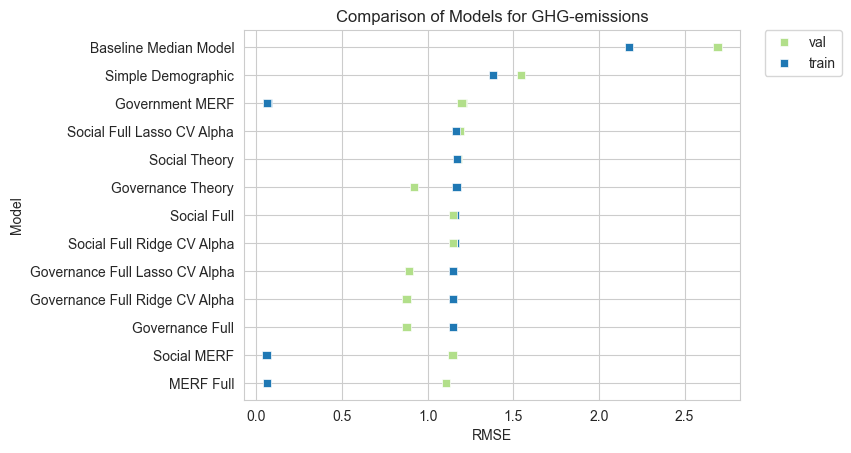

,model,split,rmse,mae,mape,r2
0,Baseline Median Model,train,2.1737,NaN,NaN,NaN
1,Baseline Median Model,val,2.6913,NaN,NaN,NaN
2,Simple Demographic,train,1.3818,NaN,NaN,NaN
3,Simple Demographic,val,1.5445,NaN,NaN,NaN
4,Social Theory,train,1.1698,NaN,NaN,NaN
5,Social Theory,val,1.1779,NaN,NaN,NaN
6,Social Full,train,1.1597,NaN,NaN,NaN
7,Social Full,val,1.1490,NaN,NaN,NaN
8,Governance Theory,train,1.1684,NaN,NaN,NaN
9,Governance Theory,val,0.9191,NaN,NaN,NaN


In [125]:

val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for GHG-emissions')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()
display(val_df)

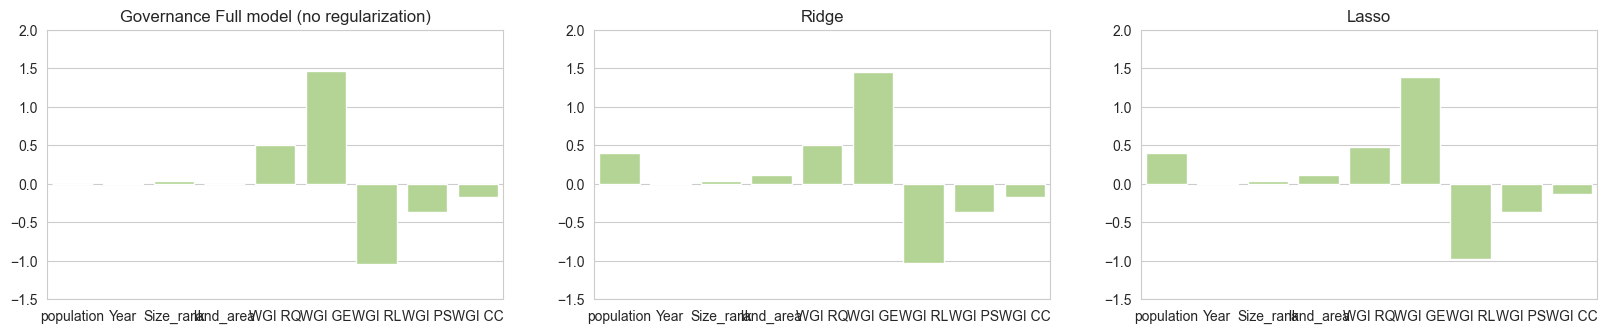

In [121]:
fig, ax = plt.subplots(ncols=3, figsize=(20,3.5))
sns.barplot(x=X_train_selected.columns, y=lasso_reg.coef_, ax=ax[2], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=ridge_reg.coef_, ax=ax[1], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=gov_full.coef_, ax=ax[0], color=sns.color_palette('Paired')[2])
for a in ax:
    a.set_ylim(-1.5,2)
ax[2].set_title('Lasso')
ax[1].set_title('Ridge')
ax[0].set_title('Governance Full model (no regularization)')
ax[2].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlabel('')
plt.show()

# Compare and evaluate all models on test


In [126]:
perf_df = pd.DataFrame(performances)

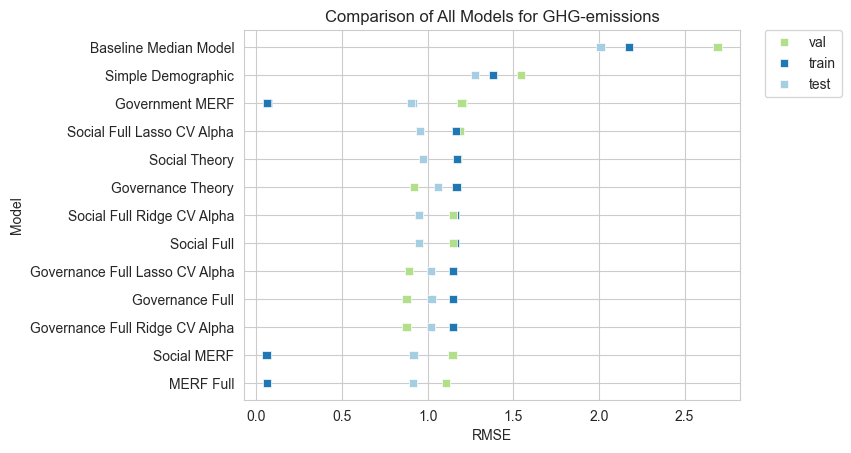

In [127]:

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of All Models for GHG-emissions')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()


In [ ]:
display(perf_df)

,model,split,rmse,mae,mape,r2
0,Baseline Median Model,train,2.8743,NaN,NaN,NaN
1,Baseline Median Model,val,3.0798,NaN,NaN,NaN
2,Baseline Median Model,test,3.3197,NaN,NaN,NaN
3,Simple Demographic,train,1.2926,NaN,NaN,NaN
4,Simple Demographic,val,1.4407,NaN,NaN,NaN
5,Simple Demographic,test,1.1598,NaN,NaN,NaN
6,Social Theory,train,1.2804,NaN,NaN,NaN
7,Social Theory,val,1.4244,NaN,NaN,NaN
8,Social Theory,test,1.1839,NaN,NaN,NaN
9,Social Full,train,1.2792,NaN,NaN,NaN


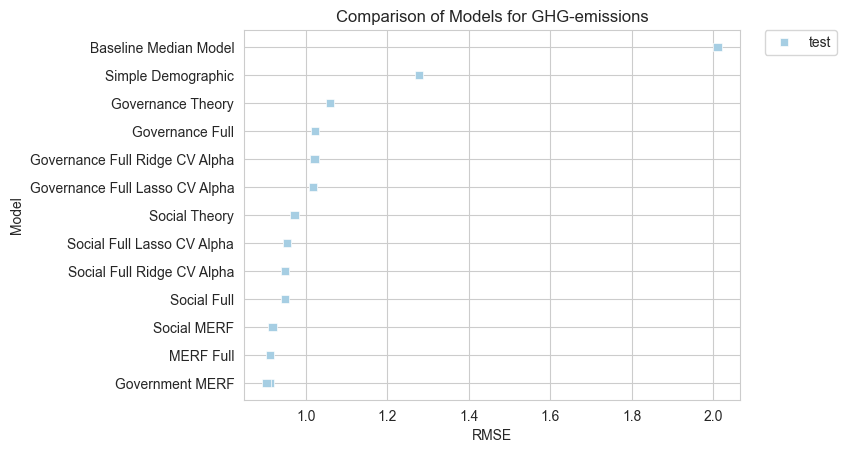

,model,split,rmse,mae,mape,r2
0,Baseline Median Model,test,2.0100,NaN,NaN,NaN
1,Simple Demographic,test,1.2779,NaN,NaN,NaN
2,Social Theory,test,0.9723,NaN,NaN,NaN
3,Social Full,test,0.9492,NaN,NaN,NaN
4,Governance Theory,test,1.0595,NaN,NaN,NaN
5,Governance Full,test,1.0219,NaN,NaN,NaN
6,MERF Full,test,0.9129,0.7269,0.8040,0.7896
7,Government MERF,test,0.9110,0.7075,0.8158,0.7905
8,Social MERF,test,0.9180,0.7491,0.9047,0.7872
9,Government MERF,test,0.9034,NaN,NaN,NaN


In [128]:

test_df = perf_df[perf_df['split'] == 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=test_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for GHG-emissions')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()
display(test_df)